In [13]:
# All imports required
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import scipy.io as io
from PIL import Image
from numpy.linalg import inv

Writing a function for point projection without radial distortion correction

In [14]:
def project_points(x_3d_w, k_matrix, rot_mats, t_vecs, dist_flag=False, dist_params=None):
    
    one_dimensional_matrix=np.array([[0,0,0,1],[0,0,0,1],[0,0,0,1],[0,0,0,1],[0,0,0,1],[0,0,0,1],[0,0,0,1],[0,0,0,1],[0,0,0,1],[0,0,0,1],[0,0,0,1],[0,0,0,1],[0,0,0,1],[0,0,0,1],[0,0,0,1],[0,0,0,1],[0,0,0,1],[0,0,0,1],[0,0,0,1],[0,0,0,1],[0,0,0,1],[0,0,0,1],[0,0,0,1],[0,0,0,1],[0,0,0,1]]).reshape(25,1,4)
    zero_dimensional_matrix=np.array([0,0,0]).reshape(3,1)
    K=np.concatenate((k_matrix,zero_dimensional_matrix),axis=1)

    hstack=np.concatenate((rot_mats,t_vecs),axis=2)
    vstack=np.concatenate((hstack,one_dimensional_matrix),axis=1) #vstack is the 4x4 matrix of rotation translation and [0,0,0,1] at the bottom
    P=np.matmul(K,vstack)
    onematrix=np.array([1]).reshape(1,1)
    

    i=0
    j=0

    for i in range(25):
        p1=P[i,:,:]
        
        
        for j in range(40):
            row=x_3d_w[i,j,:]
            column=row.reshape(3,1)
            Centre_Point=np.vstack((column,onematrix))
            
            if j==0:
                UVW=np.matmul(p1,Centre_Point)
                continue
            uvwcoordinate=np.matmul(p1,Centre_Point)
            UVW=np.append(UVW,uvwcoordinate,axis=1)
        if i==0:
            XYZ=[UVW]
        else:
            XYZ=np.append(XYZ,[UVW],axis=0)

    a=0
    b=0
    for a in range(25):
        for b in range(40):
            u=XYZ[a,0,b]
            v=XYZ[a,1,b]
            w=XYZ[a,2,b]
            
            if b==0:
                x=[u/w]
                y=[v/w]
                
            else:
                x1=[u/w]
                y1=[v/w]
                x=np.append(x,x1)
                y=np.append(y,y1)
        if a==0:
            X=[x]
            Y=[y]
        else:
            X=np.append(X,[x],axis=0)
            Y=np.append(Y,[y],axis=0)
    XY=np.append([X],[Y],axis=0)
    return XY


Writing a function for projecting points after radial distortion correction

In [15]:
def project_and_draw(imgs, x_3d_w, k_matrix, rot_mats, t_vecs, dist_flag, dist_params):
    
    kinverse=inv(k_matrix)
    onematrix=np.array([1]).reshape(1,1)
    XY=project_points(x_3d_w, k_matrix, rot_mats, t_vecs, dist_flag=False, dist_params=None)
    if dist_flag==False:
        
        f=0
        k=0
        for f in range(25):
            for k in range(40):
                xpoint=XY[0,f,k]
                ypoint=XY[1,f,k]
                plt.plot(xpoint,ypoint,marker='o',color="red") 
            plt.axis('off')
            plt.imshow(imgs[f,:,:,:])
            plt.savefig(f"results/no_correction_{f}.png",bbox_inches='tight', pad_inches=0)
            plt.show()
    
    
    
    elif dist_flag==True:
        p=0
        for p in range(5):
            if p==0:
                k1=dist_params[p,]
            elif p==1:
                k2=dist_params[p,]
            elif p==2:
                k3=dist_params[p,]
            elif p==3:
                k4=dist_params[p,]
            elif p==4:
                k5=dist_params[p,]
        
        p=0
        q=0
        for p in range(25):
            for q in range(40):
                xnynzn=XY[:,p,q]
                xnynzn=xnynzn.reshape(2,1)
                xnynzn=np.vstack((xnynzn,onematrix))
                if q==0:
                    XNYNZN=np.matmul(kinverse,xnynzn)
                    continue
                XNYNZNcoordinate=np.matmul(kinverse,xnynzn)
                XNYNZN=np.append(XNYNZN,XNYNZNcoordinate,axis=1)
            if p==0:
                UNVNWN=[XNYNZN]
            else:
                UNVNWN=np.append(UNVNWN,[XNYNZN],axis=0)


        i=0
        j=0

        for i in range(25):
            for j in range(40):
                xn=UNVNWN[i,0,j]
                yn=UNVNWN[i,1,j]
                zn=UNVNWN[i,2,j]
                r2=math.sqrt(xn*xn+yn*yn)
                dst=1+k1*r2**2+k2*r2**4+k5*r2**6
                
                if j==0:
                    xd=[xn*dst]
                    yd=[yn*dst]
                    zd=zn
                else:
                    xd1=[xn*dst]
                    yd1=[yn*dst]
                    zd1=zn
                    xd=np.append(xd,xd1)
                    yd=np.append(yd,yd1)
                    zd=np.append(zd,zd1)
            if i==0:
                XD=[xd]
                YD=[yd]
                ZD=[zd]
            else:
                XD= np.append(XD,[xd],axis=0)
                YD=np.append(YD,[yd],axis=0)
                ZD=np.append(ZD,[zd],axis=0)
        XDYD=np.append([XD],[YD],axis=0)
        XDYDZD=np.append(XDYD,[ZD],axis=0)

        p=0
        q=0
        for p in range(25):
            for q in range(40):
                udvdwd=XDYDZD[:,p,q]

                if q==0:
                    UDVDWD=np.matmul(k_matrix,udvdwd)
                    UDVDWD=UDVDWD.reshape(3,1)
                    
                    continue
                udvdwdcoordinate=np.matmul(k_matrix,udvdwd)
                udvdwdcoordinate=udvdwdcoordinate.reshape(3,1)
                
                UDVDWD=np.append(UDVDWD,udvdwdcoordinate,axis=1)
            
            if p==0:
                ADBDCD=[UDVDWD]
            else:
                ADBDCD=np.append(ADBDCD,[UDVDWD],axis=0)
        

        a=0
        b=0
        for a in range(25):
            for b in range(40):
                ud=ADBDCD[a,0,b]
                vd=ADBDCD[a,1,b]
                wd=ADBDCD[a,2,b]
                
                if b==0:
                    xd=[ud/wd]
                    yd=[vd/wd]
                else:
                    xc=[ud/wd]
                    
                    yc=[vd/wd]
                    
                    xd=np.append(xd,[xc])
                    yd=np.append(yd,[yc])
            
            if a==0:
                Xd=[xd]
                
                Yd=[yd]
                
            else:
                Xd=np.append(Xd,[xd],axis=0)
                Yd=np.append(Yd,[yd],axis=0)


        f=0
        k=0
        for f in range(25):
            for k in range(40):
                xdpoint=Xd[f,k]
                ydpoint=Yd[f,k]
                plt.plot(xdpoint,ydpoint,marker='o',color="green") 
            plt.axis('off')
            plt.imshow(imgs[f,:,:,:])
            plt.savefig(f"results/with_correction_{f}.png",bbox_inches='tight', pad_inches=0)
            plt.show()

    return 0

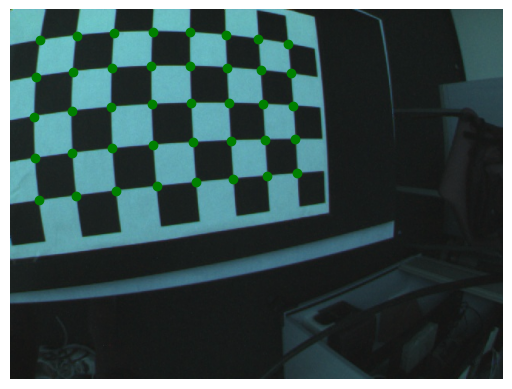

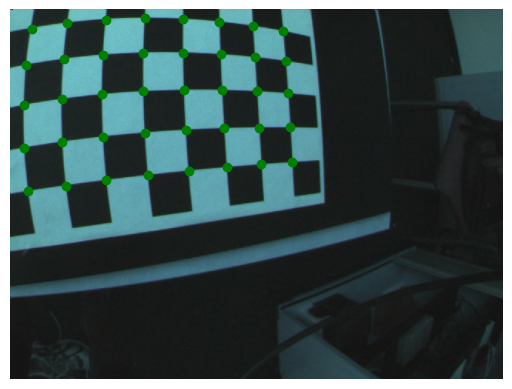

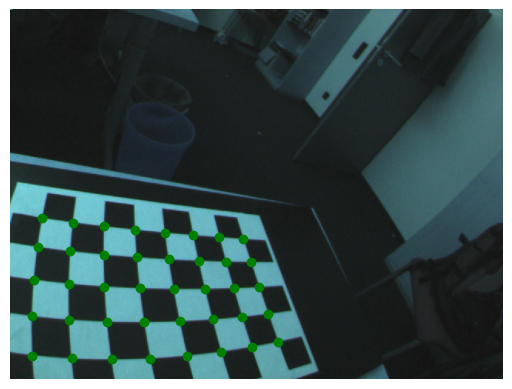

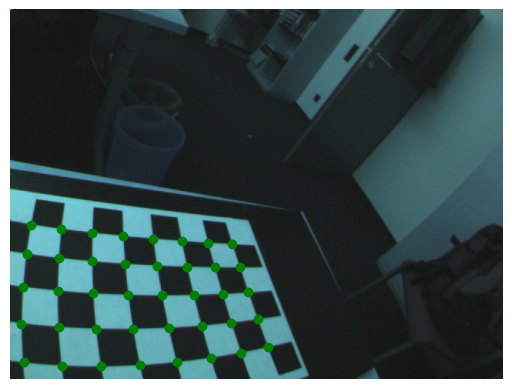

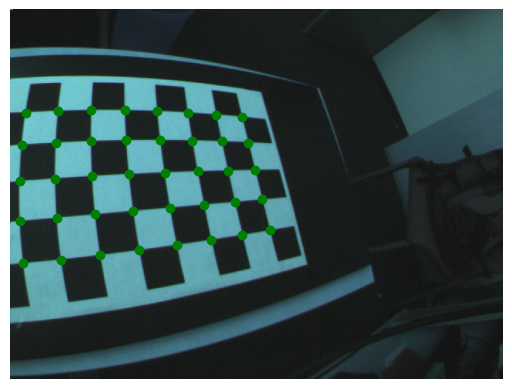

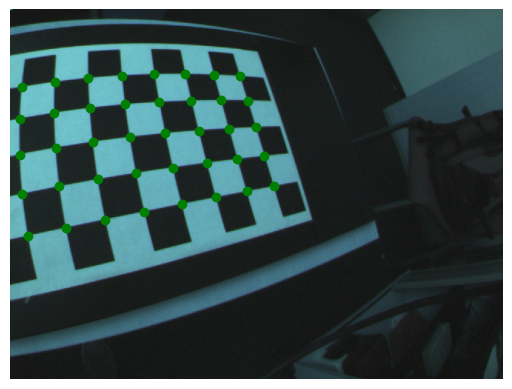

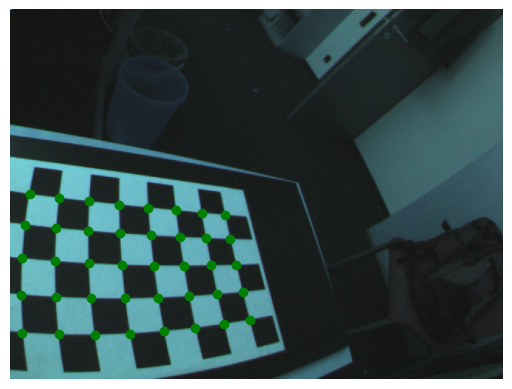

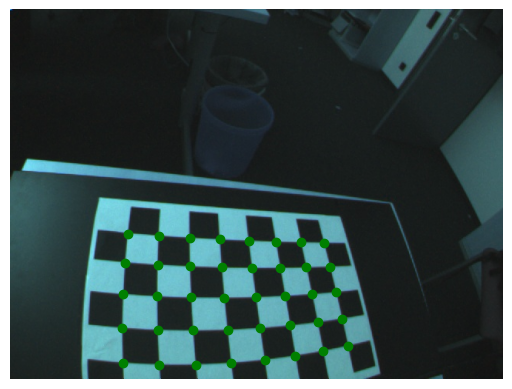

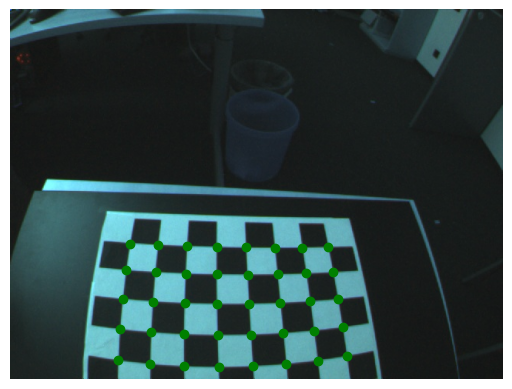

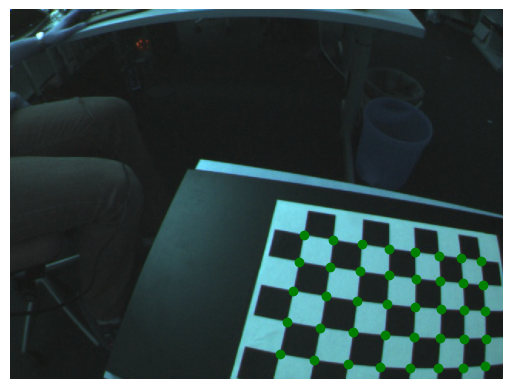

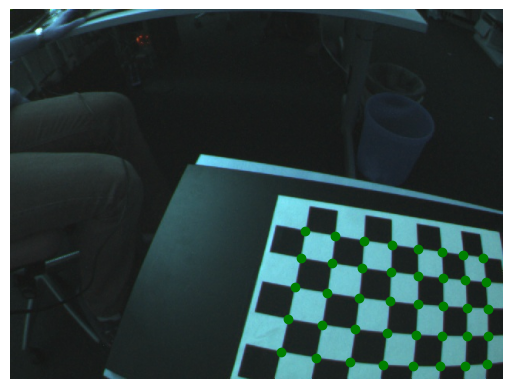

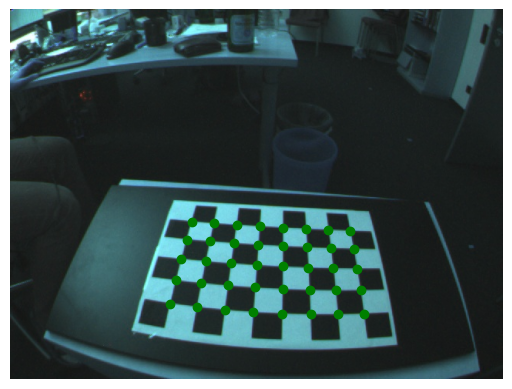

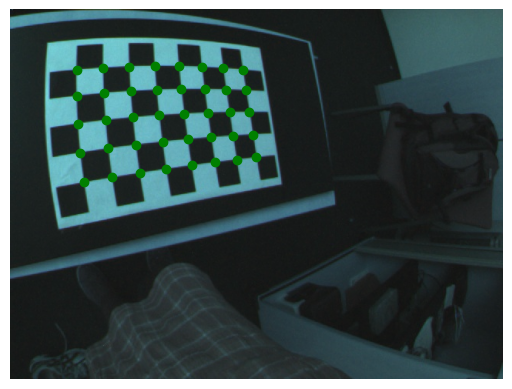

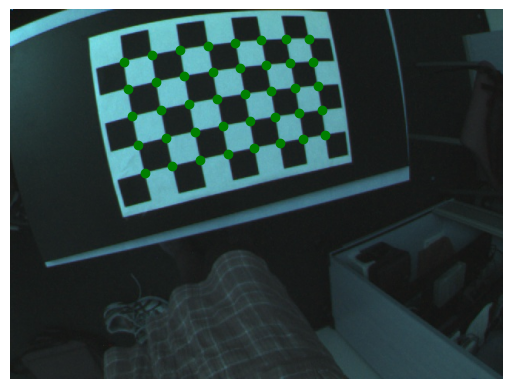

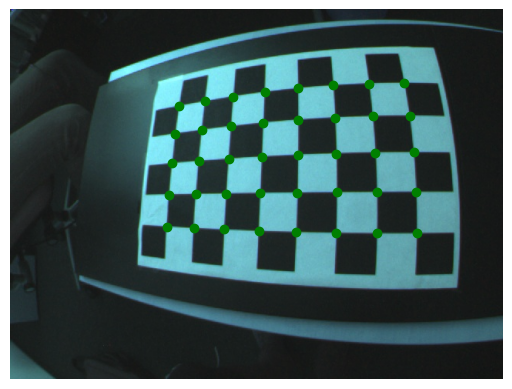

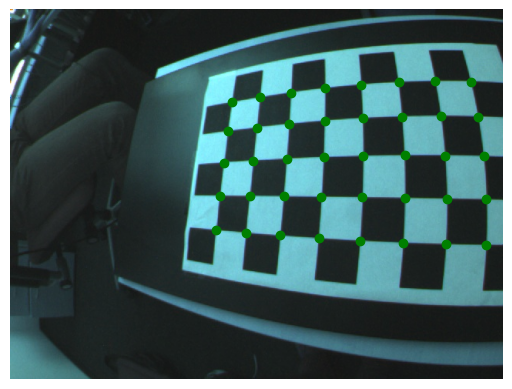

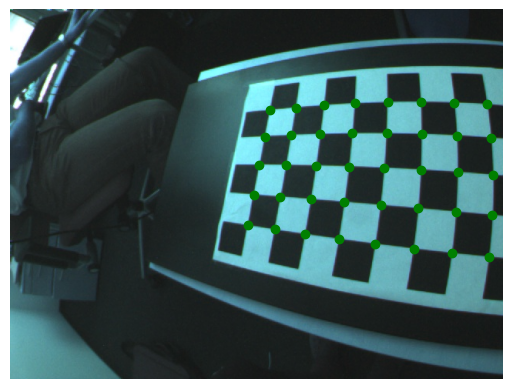

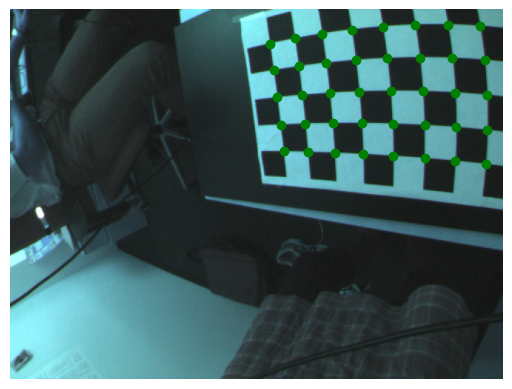

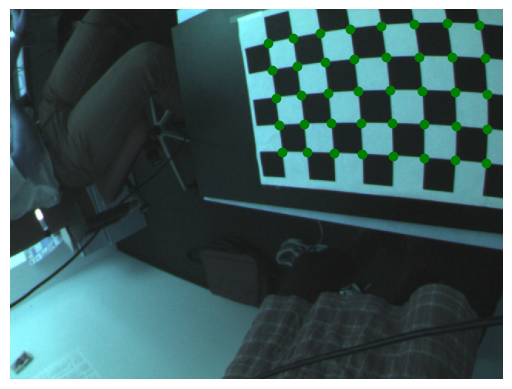

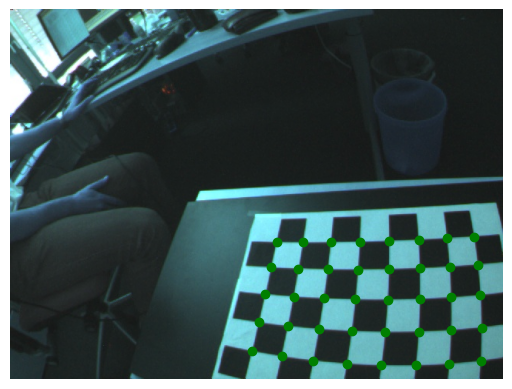

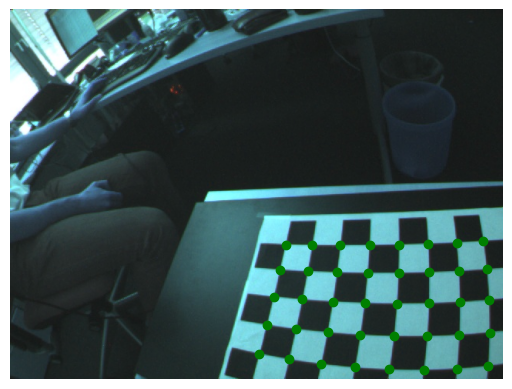

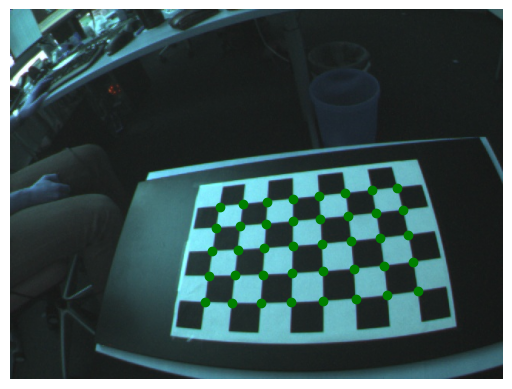

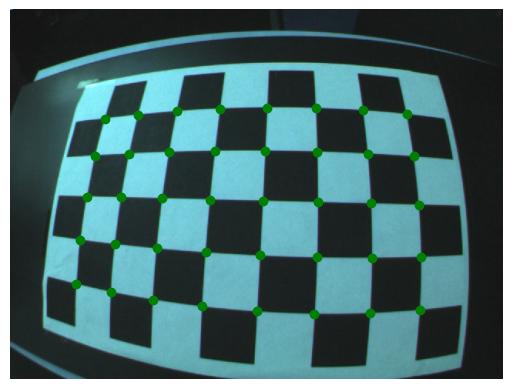

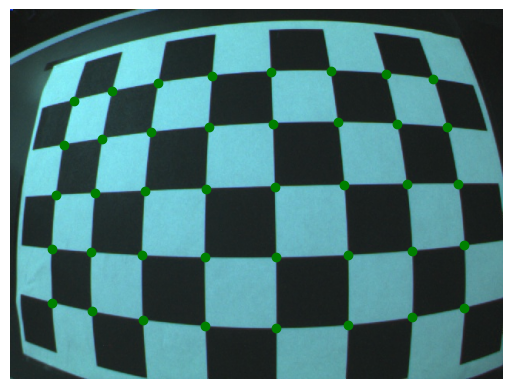

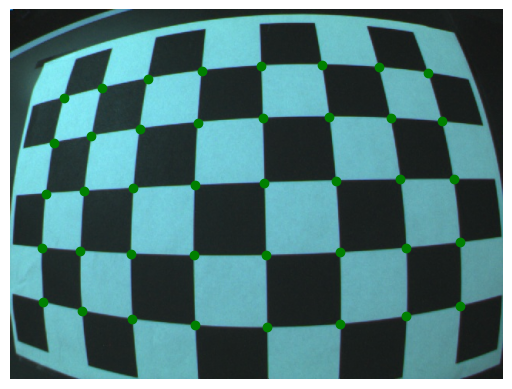

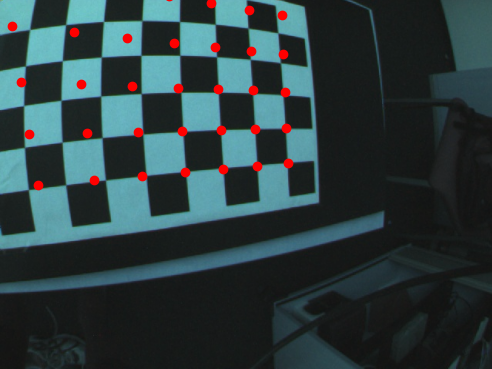

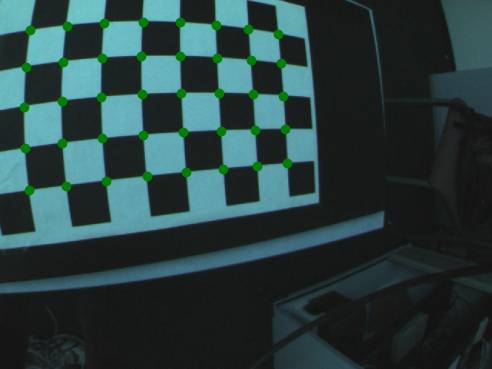

In [16]:
os.makedirs(name=f'results/', exist_ok=True)

base_folder = './data/'

# Consider distortion
dist_flag = True

# Load the data
# There are 25 views/or images/ and 40 3D points per view
data = io.loadmat('./data/calib.mat')

# 3D points in the world coordinate system
x_3d_w = data['x_3d_w'] # shape=[25, 40, 3]

# Translation vector: as the world origin is seen from the camera coordinates
t_vecs = data['translation_vecs'] # shape=[25, 3, 1]

# Rotation matrices: converts coordinates from world to camera
rot_mats = data['rot_mats'] # shape=[25, 3, 3]

# five distortion parameters
dist_params = data['distortion_params'] # shape=[5, 1]

# K matrix of the cameras
k_matrix = data['k_mat'] # shape=[3, 3]

imgs_list = [cv.imread(base_folder+str(i).zfill(5)+'.jpg') for i in range(t_vecs.shape[0])]
imgs = np.asarray(imgs_list)

project_and_draw(imgs, x_3d_w, k_matrix, rot_mats, t_vecs, dist_flag, dist_params)

without_dist_correction = Image.open('results/no_correction_0.png')
display(without_dist_correction)

with_dist_correction = Image.open('results/with_correction_0.png')
display(with_dist_correction)